In [36]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Machine Learning Engineering Nanodegree
## Project: Onde devo gastar o meu dinheiro?

## Criando base de dados

O objetivo é criar uma tabela contendo dados do crescimento do IFDM de 2012 em relação a 2011, população das cidades e gastos das cidades em cada uma das subáreas. A tabela objetivo está rotulada como gastos_ifdm_dif.

In [37]:
# Importando metodos e pacotes

import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.decomposition import PCA
import visuals as vs

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

from pandas.tools.plotting import scatter_matrix

from sets import Set

In [38]:
# Importando bases de dados

# Gastos por funcao no ano de 2012
gastos_2012 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2012.csv", encoding="utf-8")
gastos_2011 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2011.csv", encoding="utf-8")
gastos_2010 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2010.csv", encoding="utf-8")
gastos_2009 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2009.csv", encoding="utf-8")

# Codigos de identificacao dos estados e municipios
codigo_municipio = pd.read_csv("Data/Codigo municipal/CodMun2012.csv", encoding='utf-8')
codigo_estado = pd.read_csv("Data/Codigo UF/CodUF2012.csv", encoding='utf-8')

# IFDM por categoria de 2005 a 2013
ifdm_geral_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_geral_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_saude_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_saude_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_empregoRenda_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_empregoRenda_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_educacao_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_educacao_2005-2013.csv", encoding="utf_8", sep=";")

# Metricas municipais em 2010 (IDH)
municipios_metricas = pd.read_csv("Data/Municipios/municipios.csv", encoding="utf-8", sep=";", decimal=",")

In [39]:
# Seleciona apenas cidades em comum nas bases

# Unifica cidade e estado para uma unica coluna
def une_cidade_estado(df):
    uf = df["UF"].astype(str)
    mun = df["Cod Mun"].astype(str)
    df["uf_mun"] = uf+"-"+mun
    return df

une_cidade_estado(gastos_2009)
une_cidade_estado(gastos_2010)
une_cidade_estado(gastos_2011)
une_cidade_estado(gastos_2012)

# Transforma em Set e busca as cidades em comum a todas bases
int_09_10 = Set(gastos_2009.uf_mun).intersection(Set(gastos_2010.uf_mun))
int_11_12 = Set(gastos_2011.uf_mun).intersection(Set(gastos_2012.uf_mun))
int_todos = int_09_10.intersection(int_11_12)

# Seleciona as cidades remanescentes para cada base
gastos_2012 = gastos_2012[gastos_2012.uf_mun.isin(int_todos)]
gastos_2011 = gastos_2011[gastos_2011.uf_mun.isin(int_todos)]
gastos_2010 = gastos_2010[gastos_2010.uf_mun.isin(int_todos)]
gastos_2009 = gastos_2009[gastos_2009.uf_mun.isin(int_todos)]

# Ordena gastos de 2009 a 2012
gastos_2012 = gastos_2012.sort_values(["uf_mun"])
gastos_2011 = gastos_2011.sort_values(["uf_mun"])
gastos_2010 = gastos_2010.sort_values(["uf_mun"])
gastos_2009 = gastos_2009.sort_values(["uf_mun"])

# Exclui colunas em excesso
gastos_2012.drop(["Desp por Funcao Intra-Orcamentaria","Total Geral da Despesa por Funcao","uf_mun"], axis = 1, inplace = True)
gastos_2011.drop(["Desp por Funcao Intra-Orcamentaria","Total Geral da Despesa por Funcao","uf_mun"], axis = 1, inplace = True)
gastos_2010.drop(["Desp por Funcao Intra-Orcamentaria","Total Geral da Despesa por Funcao","uf_mun"], axis = 1, inplace = True)
gastos_2009.drop(["uf_mun"], axis = 1, inplace = True)

# Alinha os indices dos data frames
gastos_2011 = gastos_2011.set_index(gastos_2012.index)
gastos_2010 = gastos_2010.set_index(gastos_2012.index)
gastos_2009 = gastos_2009.set_index(gastos_2012.index)

In [40]:
# Soma os gastos dos anos
gastos_09_12 = gastos_2012.add(gastos_2011).add(gastos_2010).add(gastos_2009)
gastos_09_12["UF"] = np.divide(gastos_09_12["UF"],4)
gastos_09_12["Cod Mun"] = np.divide(gastos_09_12["Cod Mun"],4)

In [41]:
# Criando uma tabela para consulta de cidade e estado
estado_municipio = pd.merge(codigo_municipio, codigo_estado, how='inner', left_on=["CD_UF"], right_on=["CD_UF"])

In [42]:
# Filtra apenas os municipios com metricas mais recentes e busca apenas as colunas de interesse
municipio_populacao = municipios_metricas.loc[municipios_metricas['ANO'] == municipios_metricas['ANO'].max(), ['Municipio','UF','POP']]

# Trocando codigo de estado pelo nome do estado em municipio_ 
municipio_populacao = codigo_estado.merge(municipio_populacao, left_on=["CD_UF"], right_on=["UF"])
municipio_populacao.drop(['CD_UF', 'UF_y', 'ESTADO'], axis = 1, inplace = True)
municipio_populacao.rename(columns={'UF_x':'UF', 'POP':'Populacao'}, inplace=True)

display(municipio_populacao.head())

UF              Municipio  Populacao
0  RO  ALTA FLORESTA D'OESTE      24097
1  RO              ARIQUEMES      89766
2  RO                 CABIXI       6303
3  RO                 CACOAL      78141
4  RO             CEREJEIRAS      16942

In [43]:
# Cria tabela de porcentagens de gastos pelo total de gastos
uf_cod_mun = gastos_09_12.loc[:,['UF','Cod Mun']]

gastos_09_12 = gastos_09_12.drop(['UF','Cod Mun'], axis=1)
total_gastos = gastos_09_12.pop('Despesas por Funcao')

gastos_09_12_percent = gastos_09_12.div(total_gastos, axis=0)

# Remonta tabela de gastos inicial
gastos_09_12_mun = pd.concat([gastos_09_12, total_gastos, uf_cod_mun], axis=1)

# Concatena gastos ao municipio
gastos_09_12_mun_percent = pd.concat([gastos_09_12_percent, uf_cod_mun], axis=1)

In [44]:
# Adicionando nome da cidade e estado à tabela de gastos_2012
gastos_09_12_mun_percent = gastos_09_12_mun_percent.merge(estado_municipio, how='inner', left_on=["Cod Mun", "UF"], right_on=["CD_MUN", "CD_UF"])
gastos_09_12_mun_percent.drop(['CD_UF', 'CD_MUN', 'UF_x', 'Cod Mun', 'ESTADO'], axis = 1, inplace = True)
gastos_09_12_mun_percent.rename(columns={'UF_y':'UF', 'MUNICIPIO':'Municipio'}, inplace=True)

In [45]:
# Criando tabela de IFDM 
conditions = ['Codigo','Regiao','UF','Municipio']
ifdm = ifdm_geral_ano_base_2005_2013.merge(ifdm_saude_ano_base_2005_2013,on=conditions).merge(ifdm_empregoRenda_ano_base_2005_2013,on=conditions).merge(ifdm_educacao_ano_base_2005_2013,on=conditions)

# Removendo cidades sem algum valor de IFDM em algum ano
ifdm = ifdm.dropna()

# Calcula diferença do IFDM de 2012 e 2011
ifdm['ifdm_dif_saude'] = ifdm['2012_saude_nota'] - ifdm['2008_saude_nota']
ifdm['ifdm_dif_empregoRenda'] = ifdm['2012_empregoRenda_nota'] - ifdm['2008_empregoRenda_nota']
ifdm['ifdm_dif_educacao'] = ifdm['2012_educacao_nota'] - ifdm['2008_educacao_nota']
ifdm['ifdm_dif_geral'] = ifdm['2012_geral_nota'] - ifdm['2008_geral_nota']

# Filtra apenas colunas de interesse
ifdm_dif = ifdm[['Municipio','UF','Regiao','ifdm_dif_saude','ifdm_dif_empregoRenda','ifdm_dif_educacao','2012_saude_nota','2012_empregoRenda_nota','2012_educacao_nota']]
#,'ifdm_dif_geral','2012_geral_nota'

In [46]:
def remove_acentos(df, coluna):
    sem_acentos = df[coluna].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df.loc[:,coluna] = sem_acentos
    return df

# remove acentos dos nomes das cidades
gastos_09_12_mun_percent = remove_acentos(gastos_09_12_mun_percent, "Municipio")
ifdm_dif = remove_acentos(ifdm_dif, "Municipio")
municipio_populacao = remove_acentos(municipio_populacao, "Municipio")

/home/allan/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [47]:
def letras_minusculas(df, coluna):
    minusculas = df[coluna].str.lower()
    df.loc[:,coluna] = minusculas
    return df

# Coloca todas as cidades em letras minusculas
gastos_09_12_mun_percent = letras_minusculas(gastos_09_12_mun_percent, "Municipio")
ifdm_dif = letras_minusculas(ifdm_dif, "Municipio")
municipio_populacao = letras_minusculas(municipio_populacao, "Municipio")

In [48]:
# Adiciona ifdm_dif a tabela de gastos
## TODO: checar a diferenca de municipios esperada (algo perto de 5125 para a obtida de 4443)
gastos_ifdm_dif = ifdm_dif.merge(gastos_09_12_mun_percent, on=["Municipio","UF"])

# Renomeia algumas colunas
gastos_ifdm_dif.rename(columns={'Demais Subfuncoes 10':'Demais Subfuncoes Saude', 'Demais Subfuncoes 11':'Demais Subfuncoes Emprego','Demais Subfuncoes 12':'Demais Subfuncoes Educacao'}, inplace=True)

# Filtra features relacionadas a investimentos em trabalho, saude e educacao
gastos_ifdm_dif = gastos_ifdm_dif.loc[:,['ifdm_dif_saude','ifdm_dif_empregoRenda','ifdm_dif_educacao','2012_saude_nota','2012_empregoRenda_nota','2012_educacao_nota','Regiao','UF','Municipio','Saude','Atencao Basica','Assistencia Hospitalar','Suporte Profilatico','Vigilancia Sanitaria','Vigilancia Epidemiologica','Alimentacao e Nutricao','Demais Subfuncoes Saude','Trabalho','Protecao ao Trabalhador','Relacoes de Trabalho','Empregabilidade','Fomento ao Trabalho','Demais Subfuncoes Emprego','Educacao','Ensino Fundamental','Ensino Medio','Ensino Profissional','Ensino Superior','Educacao Infantil','Educacao de Jovens e Adultos','Educacao Especial','Demais Subfuncoes Educacao']]
#'ifdm_dif_geral','2012_geral_nota',

In [53]:
# Adiciona populacao a tabela de gastos
gastos_ifdm_dif = gastos_ifdm_dif.merge(municipio_populacao, on=["Municipio","UF"])

display(gastos_ifdm_dif.head())

ifdm_dif_saude  ifdm_dif_empregoRenda  ifdm_dif_educacao  \
0             0.0625                -0.0057             0.0102   
1             0.0920                -0.0182             0.1406   
2             0.0371                 0.0636             0.0674   
3             0.1379                 0.1179             0.0977   
4             0.0897                 0.1524             0.0443   
5             0.1262                -0.0937             0.0300   
6             0.1068                 0.0433             0.1131   
7             0.1877                 0.0851            -0.0022   
8            -0.0926                 0.0240             0.0739   
9             0.0482                 0.1045             0.0451   
10            0.1017                 0.1746             0.0648   
11           -0.0378                 0.0645             0.0606   
12            0.0943                 0.0877             0.0782   
13            0.0375                -0.0516             0.0903   
14            0.2011                 0.0707             0.0879   
15            0.0362                 0.1367             0.1060   
16            0.0680                 0.0202             0.0412   
17            0.1731                 0.0474             0.0783   
18           -0.0096                 0.0884            -0.0303   
19            0.1342                 0.0808             0.0332   
20            0.1108                 0.1248             0.0714   
21            0.2025                -0.1141             0.0665   
22            0.1203                 0.3357             0.1276   
23            0.1122                 0.0165             0.0418   
24            0.1704                -0.0908             0.0698   
25           -0.1042                 0.0979             0.0921   
26           -0.0029                 0.0219             0.1157   
27            0.1207                 0.0553             0.1208   
28            0.1484                 0.0376             0.0442   
29            0.0570                -0.1551             0.1121   
...              ...                    ...                ...   
4413         -0.0783                -0.0540             0.1203   
4414          0.0353                 0.0164             0.1313   
4415          0.0788                 0.0081             0.1934   
4416         -0.0907                 0.0834             0.0925   
4417         -0.0499                 0.0180             0.0131   
4418         -0.1286                 0.0952             0.0348   
4419          0.1046                 0.0189             0.1254   
4420         -0.0377                -0.0721             0.0508   
4421          0.0224                 0.1394             0.1143   
4422         -0.0749                 0.0535             0.0578   
4423          0.0488                -0.0562             0.0545   
4424          0.0013                 0.1206             0.0841   
4425          0.1053                 0.0207             0.1286   
4426          0.0540                 0.1233             0.1757   
4427          0.3035                -0.0296             0.0343   
4428          0.0706                 0.0476             0.0744   
4429          0.0750                 0.1034             0.1707   
4430         -0.0028                 0.0396             0.1010   
4431          0.0812                 0.0655             0.1193   
4432          0.2464                 0.4419             0.1183   
4433         -0.1671                 0.0430             0.0212   
4434          0.0853                -0.0914             0.0740   
4435         -0.0249                 0.0658             0.0808   
4436          0.3664                -0.0466             0.0535   
4437          0.1039                 0.0507             0.0945   
4438          0.1534                 0.0211            -0.0326   
4439         -0.1128                 0.0941             0.1155   
4440          0.1191                 0.0696             0.0918   
4441          0.0404                 0.0359   

In [50]:
# Categoriza o tamanho das cidades pela populacao
gastos_ifdm_dif['Tamanho'] = np.where(gastos_ifdm_dif['Populacao'] < 50000, 'Pequena', 
        np.where(gastos_ifdm_dif['Populacao'] < 100000, 'Media-pequena',
                np.where(gastos_ifdm_dif['Populacao'] < 300000, 'Media',
                        np.where(gastos_ifdm_dif['Populacao'] < 500000, 'Media-grande',
                                np.where(gastos_ifdm_dif['Populacao'] < 1000000, 'Grande', 'Metropole')))))

# Análise descritiva


In [51]:
# Dados
display(gastos_ifdm_dif.head())

ifdm_dif_saude  ifdm_dif_empregoRenda  ifdm_dif_educacao  2012_saude_nota  \
0          0.0625                -0.0057             0.0102           0.5759   
1          0.0920                -0.0182             0.1406           0.8373   
2          0.0371                 0.0636             0.0674           0.6419   
3          0.1379                 0.1179             0.0977           0.8258   
4          0.0897                 0.1524             0.0443           0.5596   

   2012_empregoRenda_nota  2012_educacao_nota Regiao  UF  \
0                  0.4499              0.6329  Norte  RO   
1                  0.6393              0.7606  Norte  RO   
2                  0.4650              0.7462  Norte  RO   
3                  0.7353              0.7169  Norte  RO   
4                  0.6370              0.7308  Norte  RO   

               Municipio     Saude      ...        Ensino Fundamental  \
0  alta floresta d'oeste  0.273451      ...                  0.258567   
1              ariquemes  0.240095      ...                  0.186091   
2                 cabixi  0.238619      ...                  0.272795   
3                 cacoal  0.260753      ...                  0.174964   
4             cerejeiras  0.245080      ...                  0.199923   

   Ensino Medio  Ensino Profissional  Ensino Superior  Educacao Infantil  \
0      0.000000                  0.0         0.000608           0.009761   
1      0.000000                  0.0         0.000122           0.012523   
2      0.000000                  0.0         0.000913           0.020824   
3      0.000000                  0.0         0.000000           0.040643   
4      0.011347                  0.0         0.000000           0.022167   

   Educacao de Jovens e Adultos  Educacao Especial  \
0                      0.000000           0.000000   
1                      0.002224           0.000000   
2                      0.000000           0.000000   
3                      0.000000           0.000594   
4                      0.000000           0.000992   

   Demais Subfuncoes Educacao  Populacao        Tamanho  
0                    0.000000      24097        Pequena  
1                    0.133886      89766  Media-pequena  
2                    0.000000       6303        Pequena  
3                    0.016351      78141  Media-pequena  
4                    0.000000      16942        Pequena  

[5 rows x 34 columns]

In [52]:
# Descricao dos dados pelo tamanho da cidade
g = gastos_ifdm_dif.groupby('Tamanho')

display(g.describe())

2012_educacao_nota  2012_empregoRenda_nota  \
Tamanho                                                           
Grande        count           23.000000               23.000000   
              mean             0.763557                0.743678   
              std              0.122712                0.057770   
              min              0.536900                0.610000   
              25%              0.652550                0.718100   
              50%              0.789400                0.765500   
              75%              0.866900                0.784650   
              max              0.929700                0.814800   
Media         count          184.000000              184.000000   
              mean             0.774731                0.713819   
              std              0.112463                0.103554   
              min              0.526500                0.408800   
              25%              0.686900                0.660750   
              50%              0.787350                0.742550   
              75%              0.864550                0.785750   
              max              0.974300                0.893300   
Media-grande  count           40.000000               40.000000   
              mean             0.772825                0.735743   
              std              0.113910                0.083223   
              min              0.594600                0.522600   
              25%              0.654000                0.703825   
              50%              0.778200                0.764950   
              75%              0.865550                0.796375   
              max              0.969800                0.845500   
Media-pequena count          298.000000              298.000000   
              mean             0.726124                0.621922   
              std              0.130780                0.135546   
              min              0.414400                0.225900   
              25%              0.630675                0.515275   
              50%              0.723600                0.615050   
              75%              0.833150                0.739525   
              max              0.982500                0.874700   
Metropole     count           14.000000               14.000000   
              mean             0.765429                0.767750   
              std              0.098218                0.026429   
              min              0.603100                0.725400   
              25%              0.693950                0.747875   
              50%              0.755250                0.766150   
              75%              0.836100                0.793950   
              max              0.906400                0.801700   
Pequena       count         3884.000000             3884.000000   
              mean             0.724122                0.482870   
              std              0.121722                0.121263   
              min              0.271400                0.121400   
              25%              0.637650                0.396200   
              50%              0.734350                0.466850   
              75%              0.811525                0.562200   
              max              1.000000                0.880300   

                     2012_saude_nota  Alimentacao e Nutricao  \
Tamanho                                                        
Grande        count        23.000000            2.300000e+01   
              mean          0.836570            7.958389e-04   
              std           0.075541            2.264456e-03   
              min           0.679500            0.000000e+00   
              25%           0.795900            0.000000e+00   
              50%           0.847800            0.000000e+00   
              75%           0.910900            1.866437e-04   
              max           0.938100            1.032140e-02   
Media         count       184.

In [17]:
# Utilizacao de cidades medias, media-grandes, grandes e metropoles no estudo
cidades_medias = gastos_ifdm_dif.loc[gastos_ifdm_dif['Tamanho'].isin(['Media'])]
n_cidades = len(cidades_medias)
print "Numero de cidades na base: {}".format(n_cidades)

Numero de cidades na base: 186


In [18]:
print "Cidades por estado: "
print cidades_medias['UF'].value_counts()

Cidades por estado: 
SP    52
MG    17
RJ    15
RS    14
PR    13
BA    12
SC     9
PE     8
CE     6
MA     6
ES     5
PA     5
GO     5
MT     3
MS     3
TO     2
RN     2
PB     2
SE     1
RR     1
PI     1
RO     1
AL     1
AP     1
AM     1
Name: UF, dtype: int64


In [19]:
print "Cidades por regiao: "
print cidades_medias['Regiao'].value_counts()

display(cidades_300_mais_hab.head())

Cidades por regiao: 
Sudeste         89
Nordeste        39
Sul             36
Centro-Oeste    11
Norte           11
Name: Regiao, dtype: int64


ifdm_dif_saude  ifdm_dif_empregoRenda  ifdm_dif_educacao  \
11           0.0339                -0.0035             0.0082   
87           0.0373                -0.0220             0.0003   
99           0.0189                 0.0242             0.0123   
101          0.0223                 0.1476             0.0302   
115          0.0166                 0.0209             0.0275   

     2012_saude_nota  2012_empregoRenda_nota  2012_educacao_nota Regiao  UF  \
11            0.6752                  0.7418              0.6866  Norte  RO   
87            0.6874                  0.4929              0.7602  Norte  AM   
99            0.7906                  0.6843              0.7025  Norte  RR   
101           0.5925                  0.4927              0.6163  Norte  PA   
115           0.4771                  0.5135              0.5987  Norte  PA   

      Municipio     Saude   ...     Ensino Fundamental  Ensino Medio  \
11    ji-parana  0.325083   ...               0.196993      0.000000   
87    parintins  0.251144   ...               0.333794      0.000606   
99    boa vista  0.214436   ...               0.214872      0.000000   
101  abaetetuba  0.202551   ...               0.392307      0.000000   
115    braganca  0.197402   ...               0.388222      0.000299   

     Ensino Profissional  Ensino Superior  Educacao Infantil  \
11                   0.0         0.001179           0.013021   
87                   0.0         0.000235           0.049651   
99                   0.0         0.000000           0.009224   
101                  0.0         0.000000           0.002605   
115                  0.0         0.000000           0.051415   

     Educacao de Jovens e Adultos  Educacao Especial  \
11                       0.000000           0.000595   
87                       0.000000           0.000000   
99                       0.000000           0.000000   
101                      0.010033           0.000000   
115                      0.004209           0.000000   

     Demais Subfuncoes Educacao  Populacao  Tamanho  
11                     0.003432     115896    Media  
87                     0.012355     101218    Media  
99                     0.000080     281538    Media  
101                    0.000000     140055    Media  
115                    0.064965     112709    Media  

[5 rows x 34 columns]

In [20]:
# Separa so os gastos de cada cidade

gastos = cidades_medias.copy()
gastos.drop(['ifdm_dif_saude','ifdm_dif_empregoRenda','ifdm_dif_educacao','2012_saude_nota','2012_empregoRenda_nota','2012_educacao_nota','Regiao','UF','Municipio','Tamanho','Populacao'], axis = 1, inplace = True)
#,'ifdm_dif_geral','2012_geral_nota'

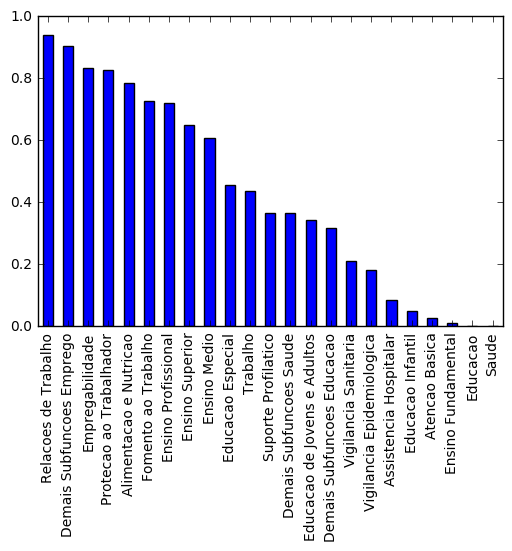

In [21]:
total_ocorrencias = gastos[gastos == 0].count()
porcentagem_ocorrencias = total_ocorrencias/n_cidades
porcentagem_ocorrencias = porcentagem_ocorrencias.sort_values(ascending=False)

porcentagem_ocorrencias.plot.bar();

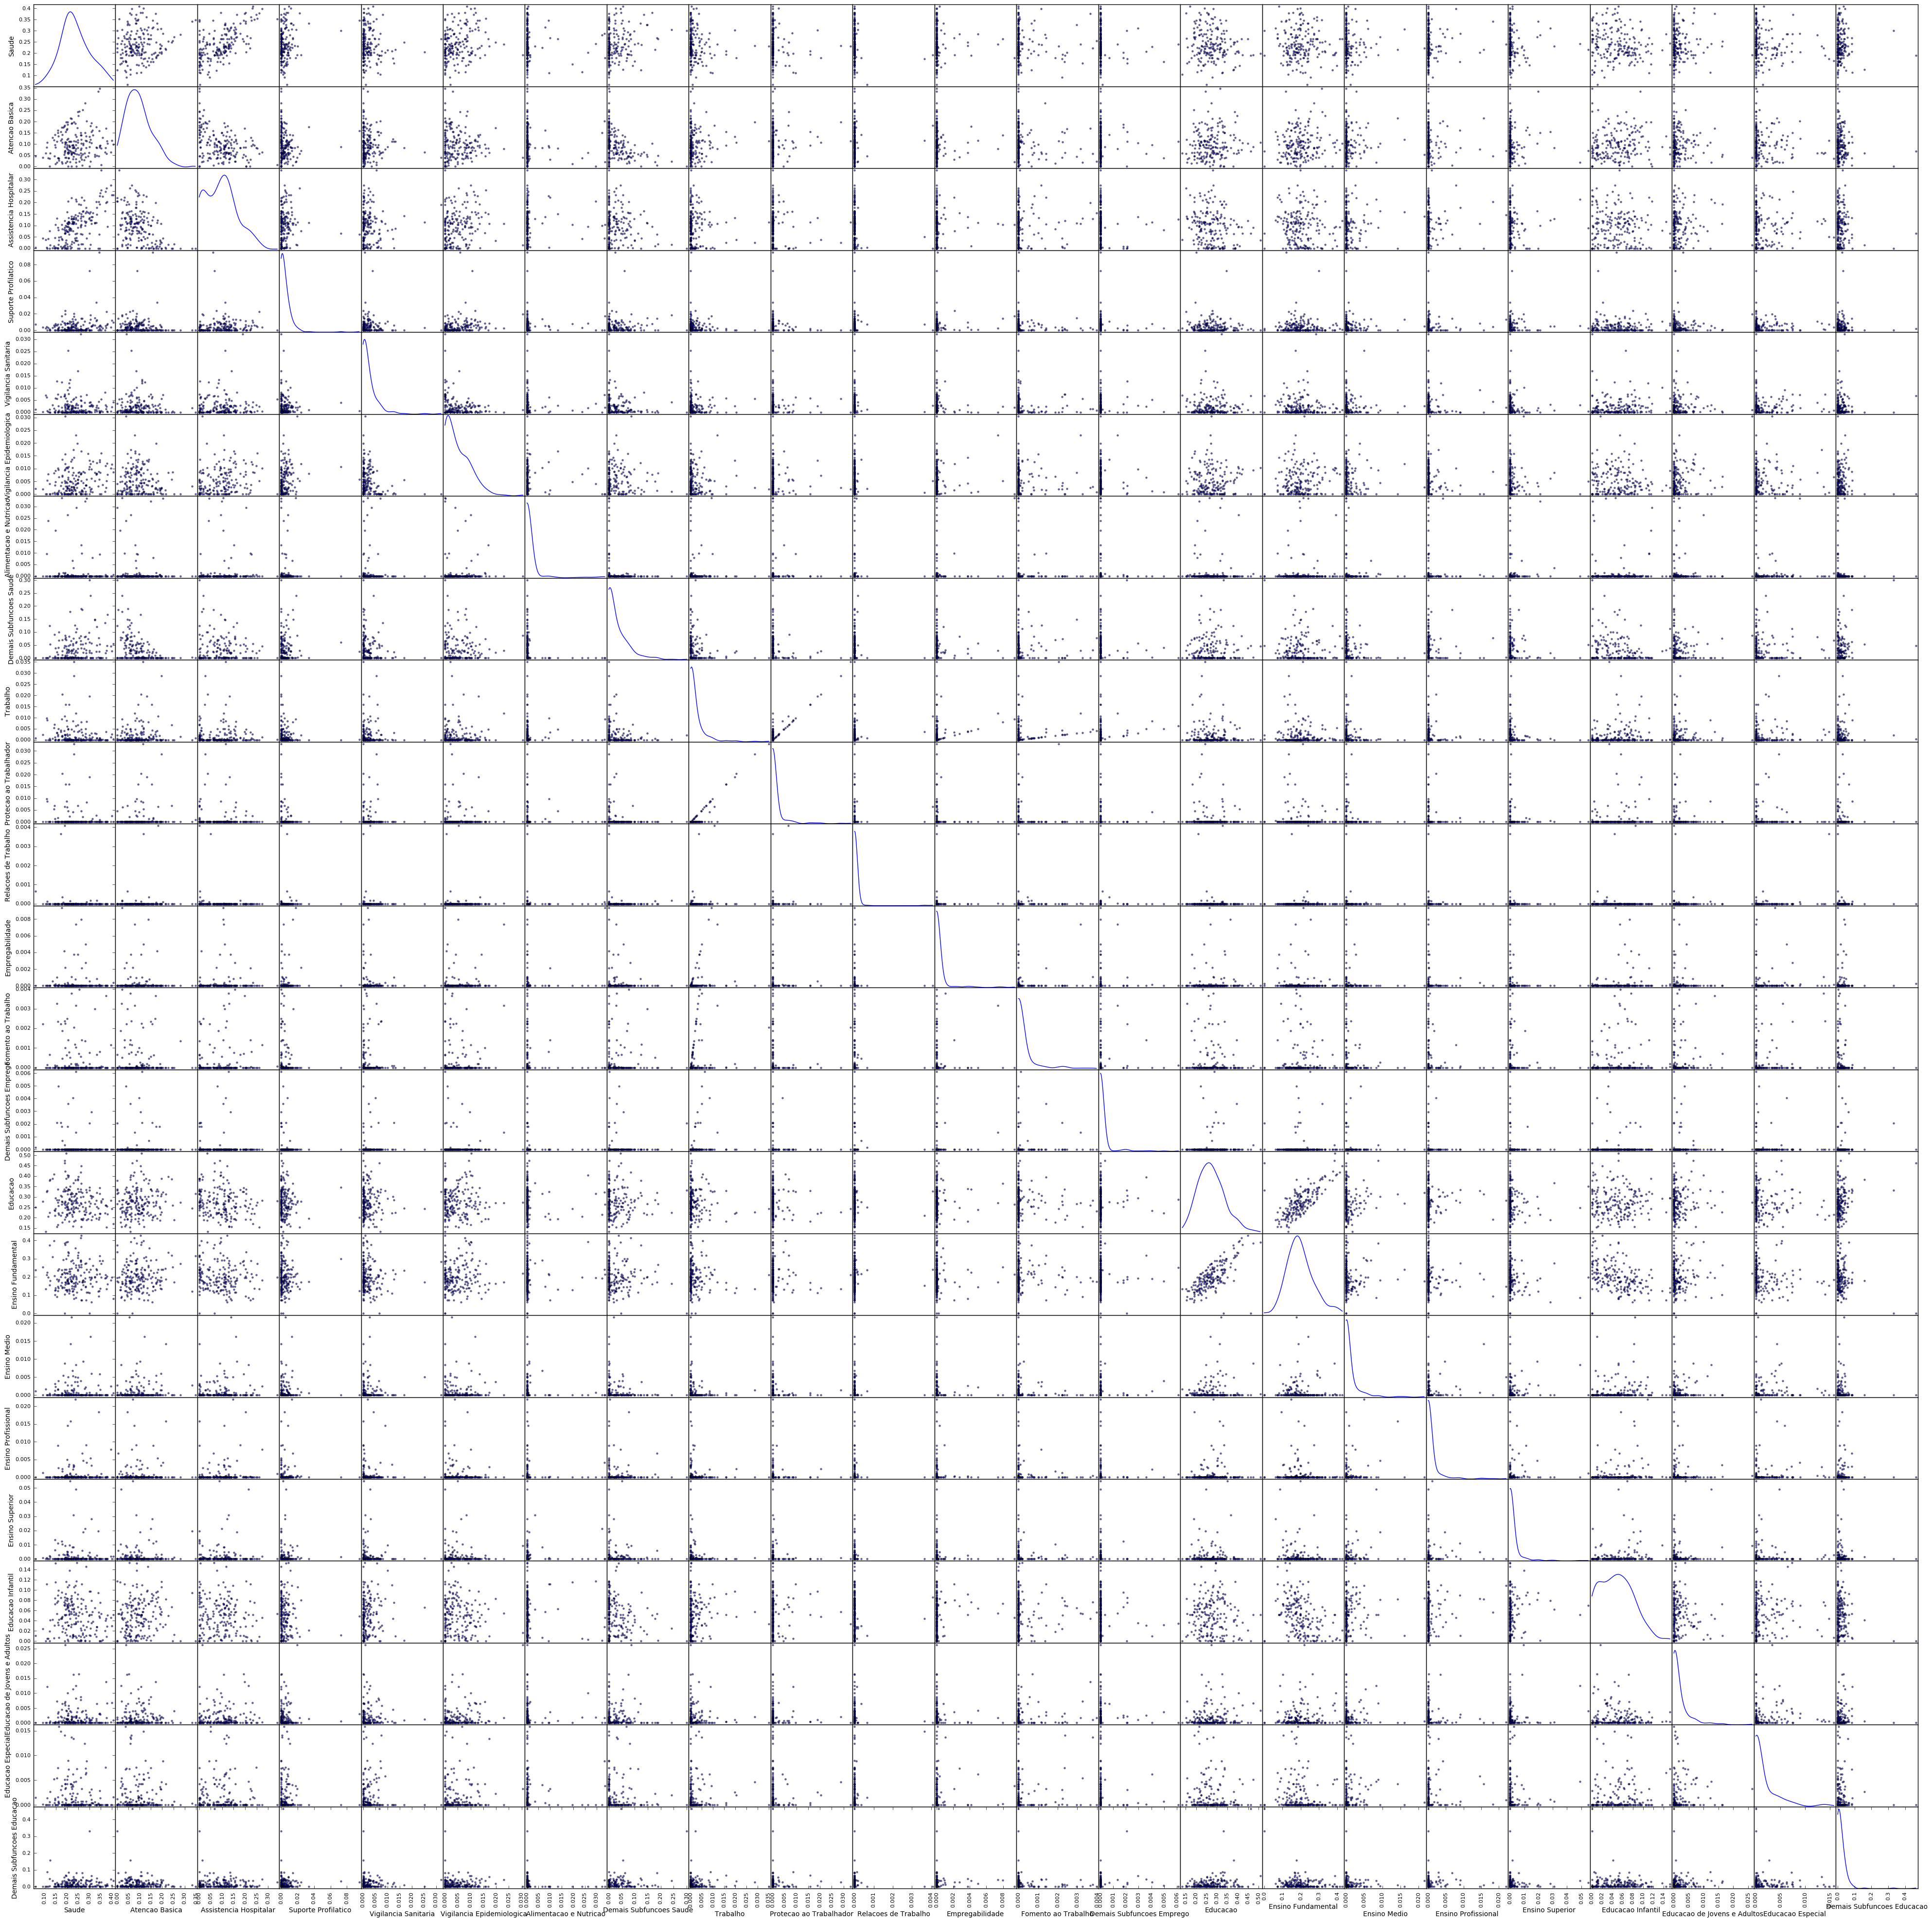

In [22]:
# Produz um scatterplot para cada par de features
scatter_matrix(gastos, figsize=(50, 50), diagonal='kde');

## Pré-processamento

In [23]:
# Encontra cidades que nao descreveram os gastos de acordo com o esperado e devem ser removidas da pesquisa
para_remover = gastos[gastos.Trabalho == 0.0].index
para_remover.append(gastos[gastos.Educacao == 0.0].index)
para_remover.append(gastos[gastos.Saude == 0.0].index)
len(para_remover)

81

In [24]:
# Remove cidades das bases utilizadas
cidades_medias = cidades_medias[~cidades_medias.index.isin(para_remover)]
gastos = gastos[~gastos.index.isin(para_remover)]

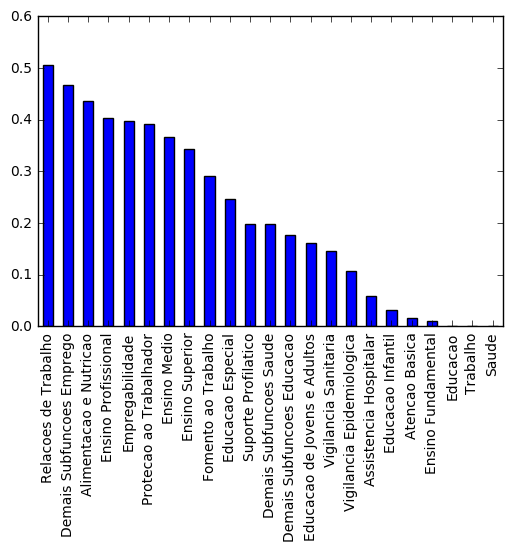

In [25]:
# Print ocorrencias de zeros
total_ocorrencias = gastos[gastos == 0].count()
porcentagem_ocorrencias = total_ocorrencias/n_cidades
porcentagem_ocorrencias = porcentagem_ocorrencias.sort_values(ascending=False)

porcentagem_ocorrencias.plot.bar();

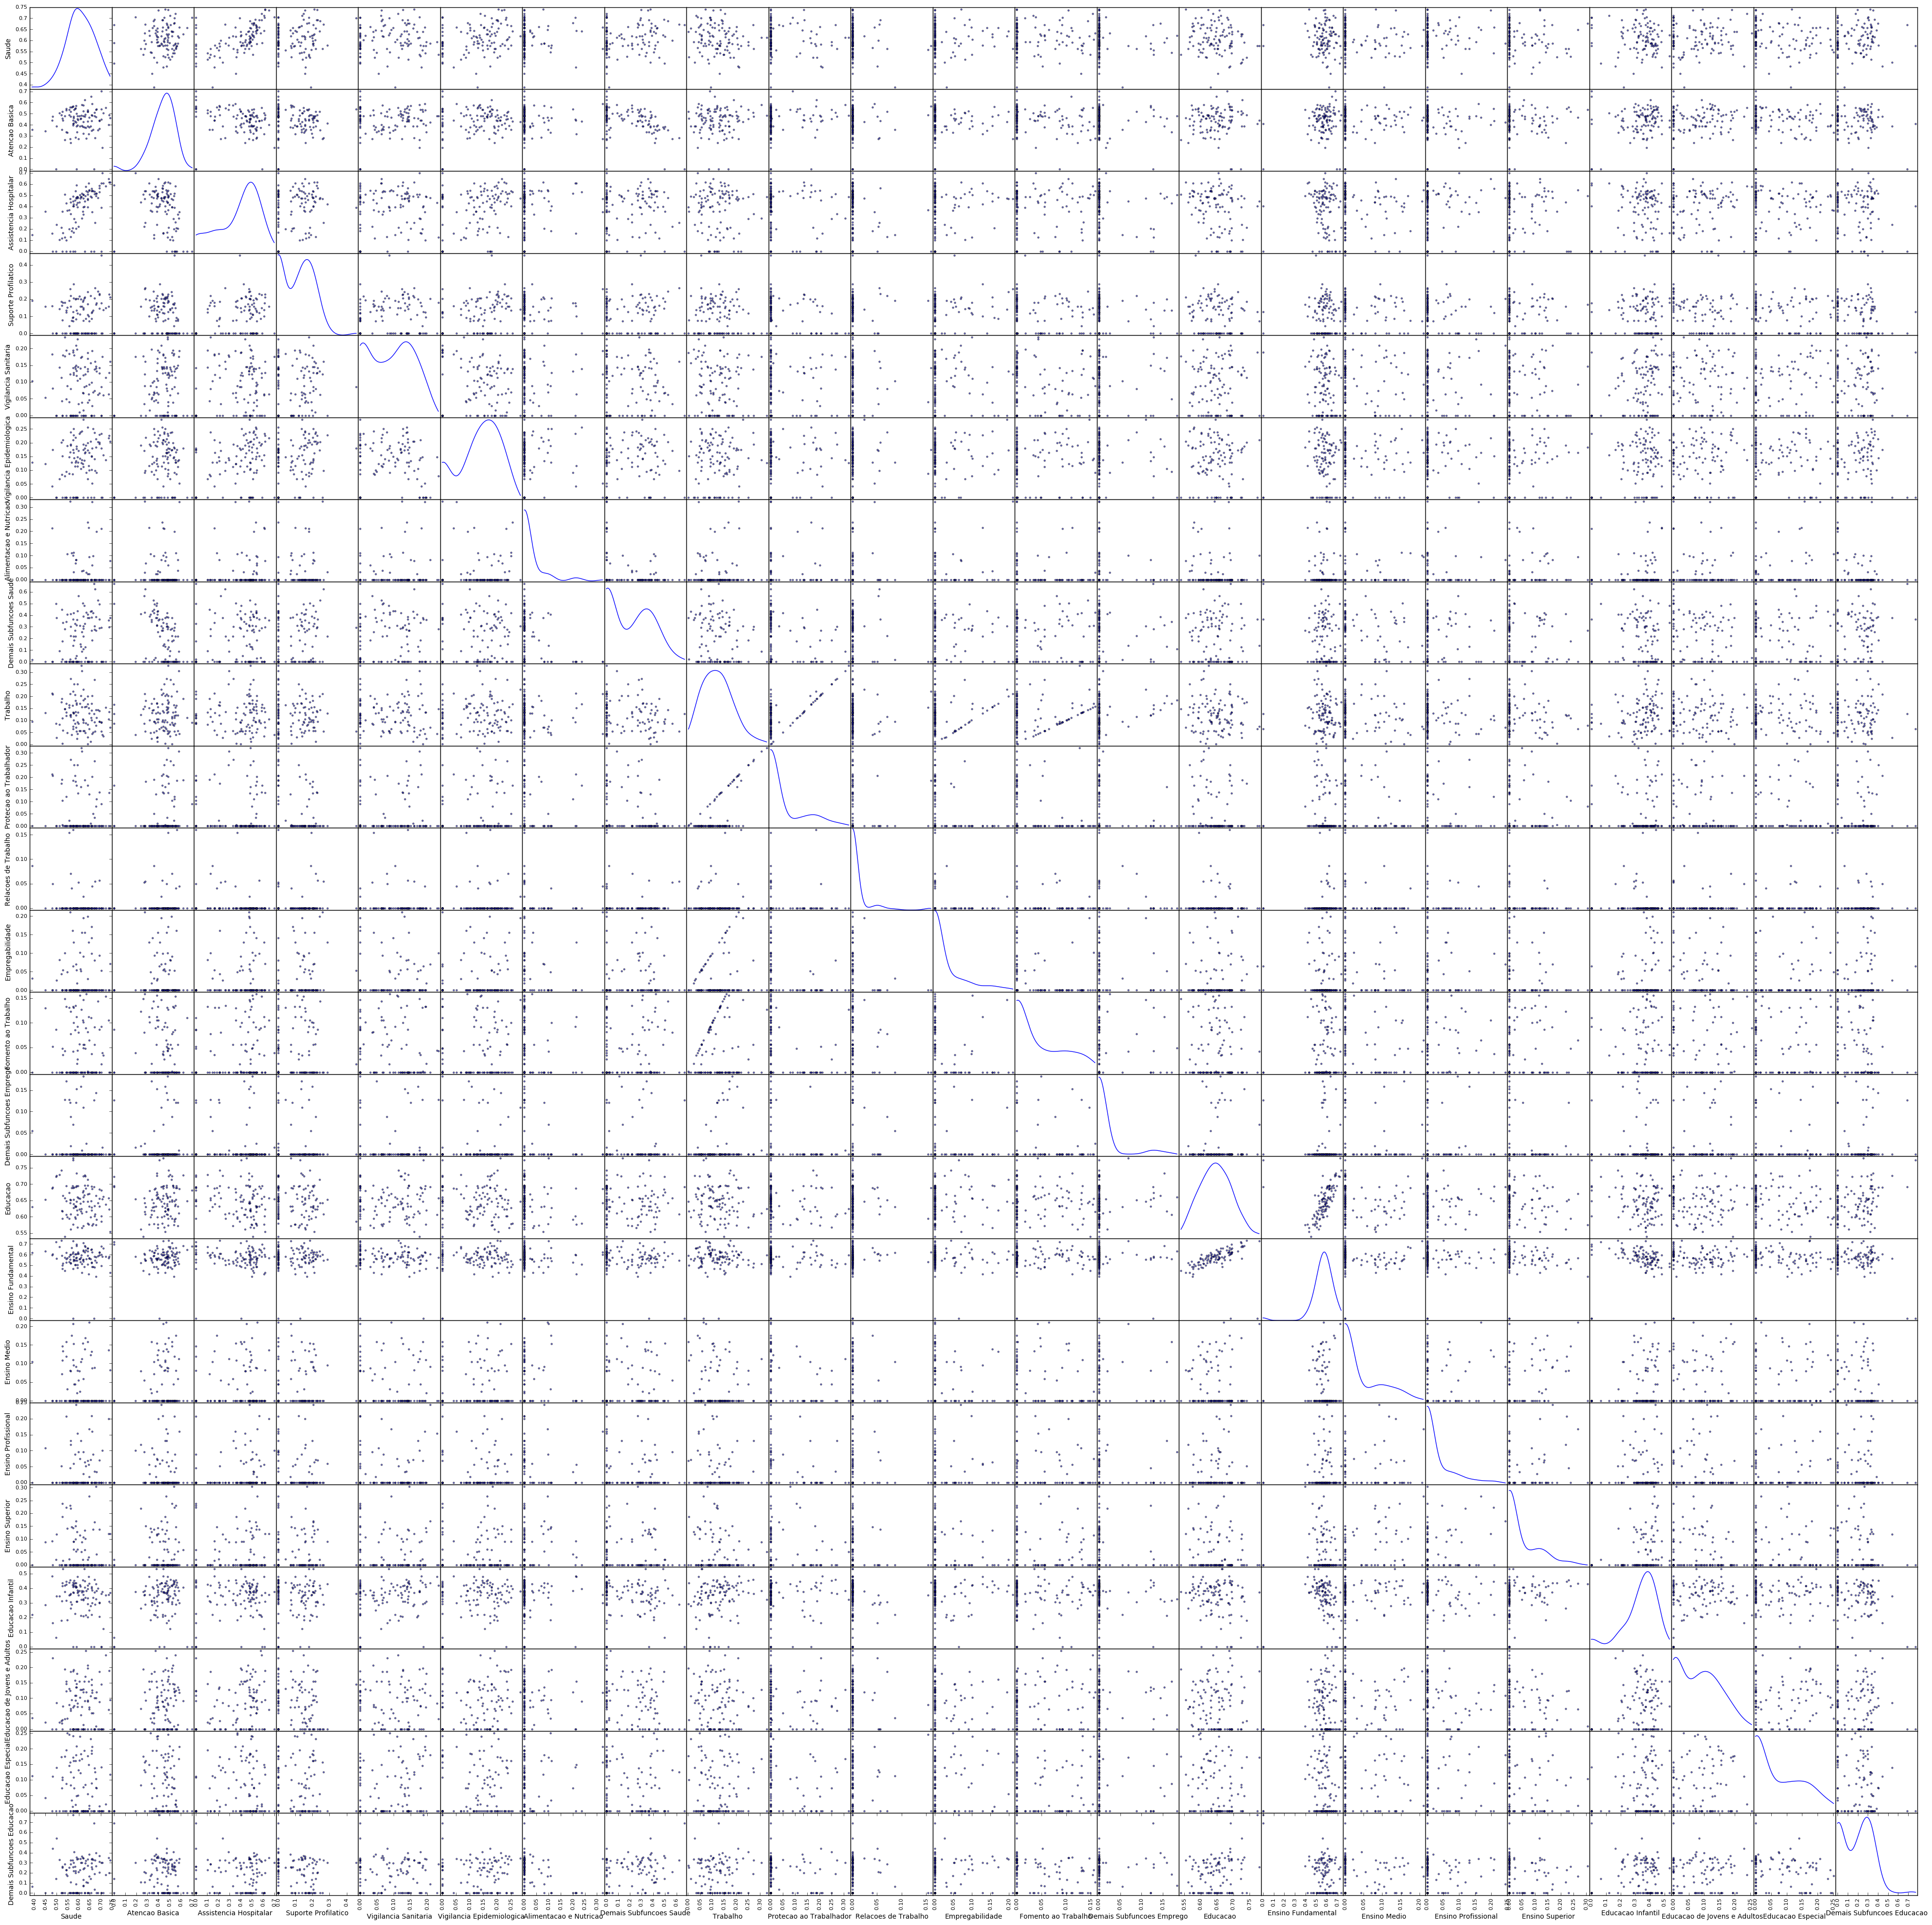

In [26]:
# Transforma os dados utilizando a raiz cubica
cbrt_gastos = np.cbrt(gastos)

# Produz um scatterplot para cada par de features
pd.scatter_matrix(cbrt_gastos, figsize = (50,50), diagonal = 'kde');

In [27]:
# retirando outliers

# Inicianilizando vetor vazio de outliers
#data = cbrt_gastos
    
#outliers = np.empty(0, dtype=int)
#for feature in data.keys():
    
#    Q1 = np.percentile(data[feature], 25)
#    Q3 = np.percentile(data[feature], 75)
    
#    step = np.multiply(1.5, Q3-Q1)
    
    # Mostra os outliers
#    out = data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))]
#    print "Data points considered outliers for the feature '{}':".format(feature)
#    display(out)
    
    # Select the indices for data points you wish to remove
#    outliers = np.append(outliers, out.index.values)

In [28]:
# Remove Trabalho, Educacao e Saude
cbrt_gastos.drop(['Saude', 'Educacao', 'Trabalho'], axis = 1, inplace = True)

# Agrupamentos por gastos

## Maiores cidades do Brasil

In [29]:
# Aplica o PCA. Numero de componentes igual ao numero de colunas
pca = PCA(n_components=len(cbrt_gastos.columns))
pca.fit(cbrt_gastos)

PCA(copy=True, n_components=20, whiten=False)

Dimensao  Variancia
0          1   0.256850
1          2   0.190784
2          3   0.100609
3          4   0.085290
4          5   0.058773
5          6   0.044879
6          7   0.039811
7          8   0.034032
8          9   0.031573
9         10   0.029610
10        11   0.026398
11        12   0.019103
12        13   0.016662
13        14   0.015469
14        15   0.012173
15        16   0.011514
16        17   0.009174
17        18   0.007813
18        19   0.006866
19        20   0.002617

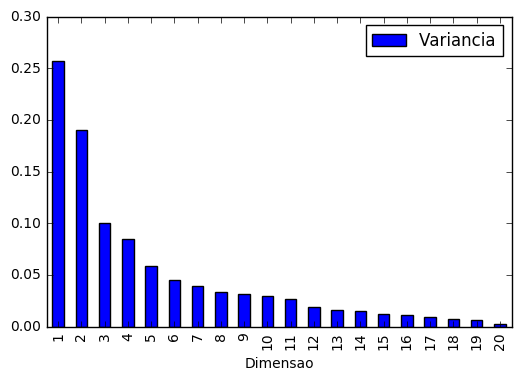

In [30]:
# Quantidade de variancia de cada componente principal
dimensoes = range(1,len(pca.components_)+1)
d = {'Variancia':pca.explained_variance_ratio_, 'Dimensao':dimensoes}
componentes = pd.DataFrame(d);

display(componentes);
componentes.plot.bar(x='Dimensao',y='Variancia');

In [31]:
# Principais atributos para cada componente
atributos_por_componente = pd.DataFrame(np.round(pca.components_, 4), columns = cbrt_gastos.keys())
atributos_por_componente.index = dimensoes
cor_area = ['g','g','g','g','g','g','g','b','b','b','b','b','r','r','r','r','r','r','r','r']

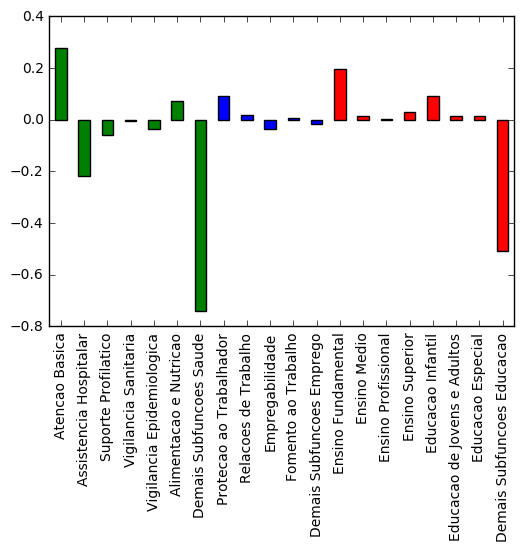

In [32]:
# Componente 1
atributos_por_componente.iloc[0,:].plot.bar(color=cor_area);

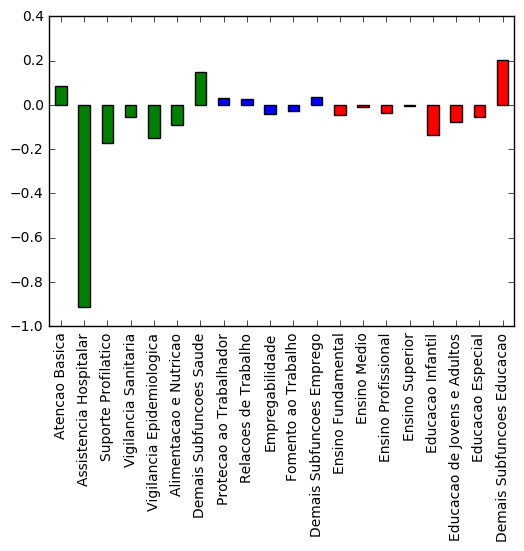

In [33]:
# Componente 2
atributos_por_componente.iloc[1,:].plot.bar(color=cor_area);

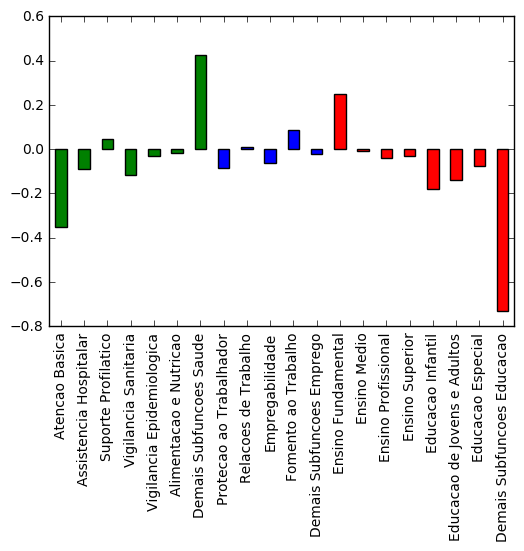

In [34]:
# Componente 3
atributos_por_componente.iloc[2,:].plot.bar(color=cor_area);

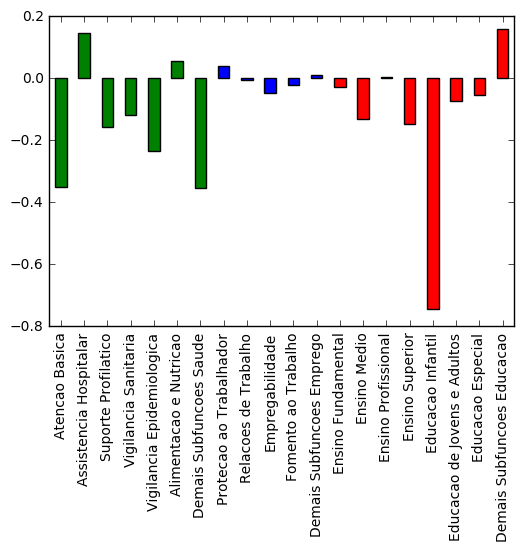

In [35]:
# Componente 4
atributos_por_componente.iloc[3,:].plot.bar(color=cor_area);

In [36]:
# Aplica o PCA e faz o fitting dos dados utilizando quatro dimensoes
pca = PCA(n_components=4)
pca.fit(cbrt_gastos)

# Transforma os dados utilizando o pca
dados_reduzidos = pca.transform(cbrt_gastos)

# Cria um dataframe para os dados em dimensoes reduzidas
dados_reduzidos = pd.DataFrame(dados_reduzidos, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4'])

In [37]:
display(dados_reduzidos.head())

Dimension 1  Dimension 2  Dimension 3  Dimension 4
0    -0.195889    -0.052771    -0.028814     0.015032
1     0.034310    -0.092341    -0.059767    -0.020556
2    -0.202701    -0.072634    -0.073729    -0.058326
3     0.402543     0.401646     0.106388     0.220185
4    -0.371849    -0.084468     0.018720    -0.030833

In [38]:
# Cria cluster e compara mostra os silhouettes
def cluster_silhouette(n_clusters, data):

    clusterer = KMeans(n_clusters, random_state=0)
    clusterer = clusterer.fit(data)

    preds = clusterer.predict(data)

    score = silhouette_score(data, preds)

    return (score, clusterer)

for x in range(2, 10):
    print "number of clusters: {}, silhouette score: {}".format(x, cluster_silhouette(x, dados_reduzidos)[0])

number of clusters: 2, silhouette score: 0.284942569725
number of clusters: 3, silhouette score: 0.300465930491
number of clusters: 4, silhouette score: 0.319460809526
number of clusters: 5, silhouette score: 0.29457386438
number of clusters: 6, silhouette score: 0.296780612716
number of clusters: 7, silhouette score: 0.285652141007
number of clusters: 8, silhouette score: 0.296363176917
number of clusters: 9, silhouette score: 0.277453043468


In [39]:
# Atribui cada ponto a um cluster

# Melhor cluster de acordo com silhouette
grupos = cluster_silhouette(4, dados_reduzidos)[1]

# Atribui os pontos aos clusters
preds = grupos.predict(dados_reduzidos)

# Acha o centro dos clusters
centros = grupos.cluster_centers_

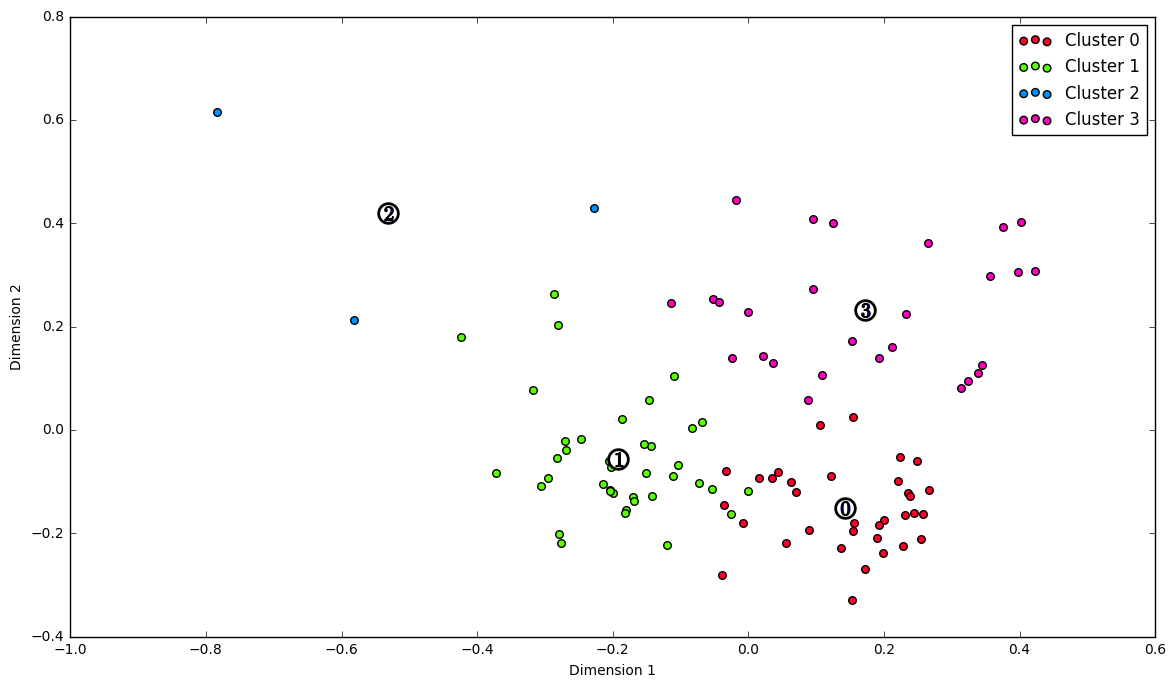

In [40]:
# Display the results of the clustering from implementation
vs.cluster_results(dados_reduzidos, preds, centros);

In [41]:
# Adiciona cluster a tabela original de cidades
cidades_medias.insert(0, 'Grupo', preds)

## Analise de grupos

In [42]:
# Analise de ifdm
cidade_ifdm_grupo = cidades_medias.loc[:,['ifdm_dif_saude',
 'ifdm_dif_empregoRenda',
 'ifdm_dif_educacao',
 'Regiao',
 'UF', 'Municipio',
 'Grupo']]

cidade_ifdm_dif_grupo = cidades_medias.loc[:,['2012_saude_nota',
 '2012_empregoRenda_nota',
 '2012_educacao_nota',
 'Regiao',
 'UF', 'Municipio',
 'Grupo']]


In [43]:
# Cria grafico de barras com legendas por fora da figura
def grafico_barras(df, titulo):
    f = plt.figure()
    plt.title(titulo)
    df.plot(kind='bar', ax=f.gca())
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

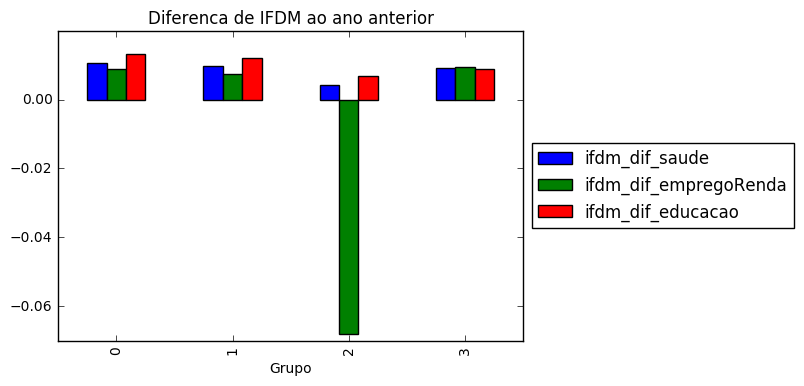

In [44]:
ifdm_grupos = cidade_ifdm_grupo.groupby('Grupo').mean();

grafico_barras(ifdm_grupos, "Diferenca de IFDM ao ano anterior");

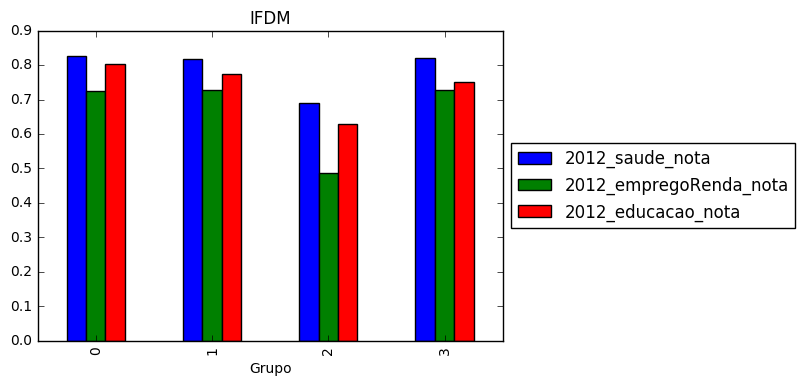

In [45]:
ifdm_dif_grupos = cidade_ifdm_dif_grupo.groupby('Grupo').mean();
grafico_barras(ifdm_dif_grupos, "IFDM");

In [46]:
# Tamanho das cidades dos grupos
tam_grupo = cidades_medias.loc[:,['Tamanho','Grupo']]
for grupo in tam_grupo.Grupo.unique():
    print "Grupo: {}".format(grupo);
    display(tam_grupo[tam_grupo.Grupo == grupo].Tamanho.value_counts());


Grupo: 1


Media    41
Name: Tamanho, dtype: int64

Grupo: 0


Media    34
Name: Tamanho, dtype: int64

Grupo: 3


Media    27
Name: Tamanho, dtype: int64

Grupo: 2


Media    3
Name: Tamanho, dtype: int64

Saude  Trabalho  Educacao
Grupo                              
0      0.236050  0.004192  0.266593
1      0.264296  0.002784  0.263637
2      0.204598  0.000992  0.390692
3      0.181448  0.004603  0.291546

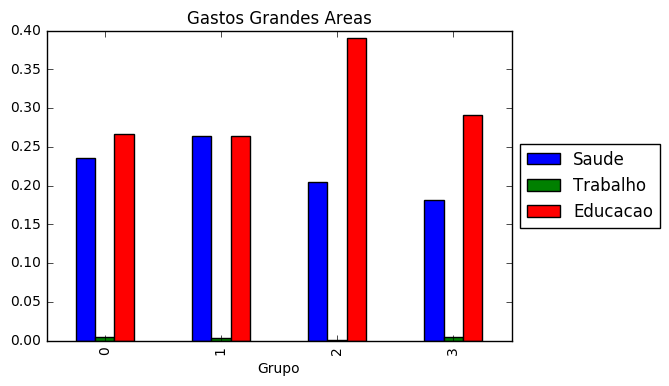

In [47]:
saude_grupo = cidades_medias.loc[:,['Grupo','Saude','Trabalho','Educacao']]
sg_ste = saude_grupo.groupby('Grupo').mean();
display(sg_ste)
    
grafico_barras(sg_ste, "Gastos Grandes Areas");

Atencao Basica  Assistencia Hospitalar  Suporte Profilatico  \
Grupo                                                                
0            0.091631                0.130063             0.003640   
1            0.073689                0.115312             0.007175   
2            0.022519                0.021925             0.000683   
3            0.156250                0.006295             0.001895   

       Vigilancia Sanitaria  Vigilancia Epidemiologica  \
Grupo                                                    
0                  0.002229                   0.004195   
1                  0.001581                   0.006362   
2                  0.002223                   0.000000   
3                  0.002488                   0.002871   

       Alimentacao e Nutricao  Demais Subfuncoes Saude  
Grupo                                                   
0                    0.003293                 0.000998  
1                    0.000068                 0.060108  
2                    0.000000                 0.157249  
3                    0.000425                 0.011223

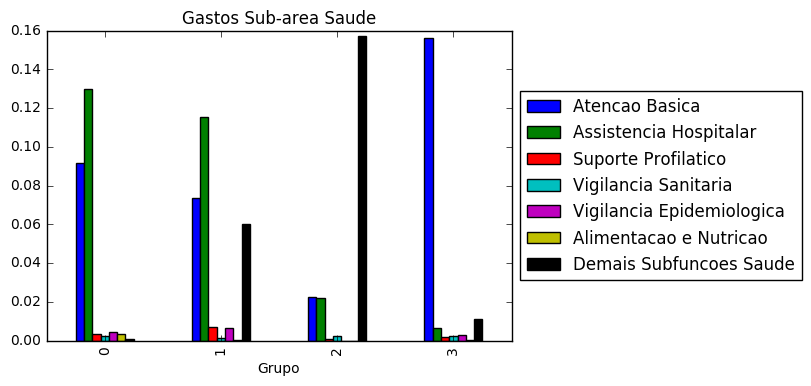

In [48]:
# Gastos das cidades em saude
saude_grupo = cidades_medias.loc[:,['Grupo','Atencao Basica','Assistencia Hospitalar','Suporte Profilatico','Vigilancia Sanitaria','Vigilancia Epidemiologica','Alimentacao e Nutricao','Demais Subfuncoes Saude']]
sg_f = saude_grupo.groupby('Grupo').mean();
display(sg_f)
    
grafico_barras(sg_f, "Gastos Sub-area Saude");

Protecao ao Trabalhador  Relacoes de Trabalho  Empregabilidade  \
Grupo                                                                   
0                     0.002623              0.000110         0.000591   
1                     0.001156              0.000012         0.000726   
2                     0.000000              0.000000         0.000089   
3                     0.003409              0.000195         0.000222   

       Fomento ao Trabalho  Demais Subfuncoes Emprego  
Grupo                                                  
0                 0.000559                   0.000309  
1                 0.000577                   0.000314  
2                 0.000219                   0.000685  
3                 0.000456                   0.000321

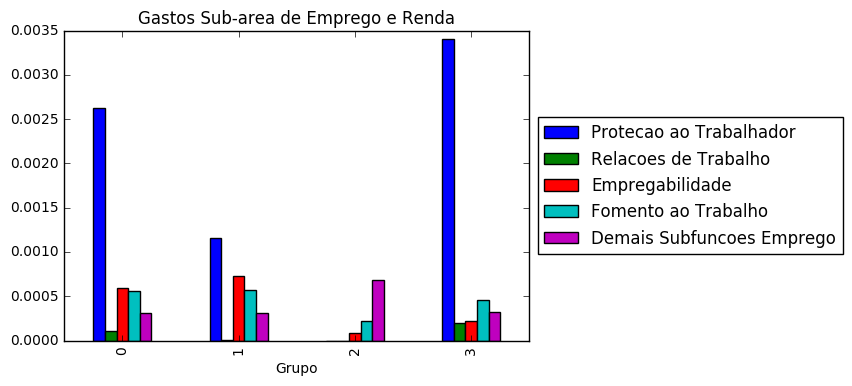

In [49]:
# Gastos das cidades em emprego e renda
emprego_grupo = cidades_medias.loc[:,['Grupo','Protecao ao Trabalhador','Relacoes de Trabalho','Empregabilidade','Fomento ao Trabalho','Demais Subfuncoes Emprego']]
sg_er = emprego_grupo.groupby('Grupo').mean();
display(sg_er)

grafico_barras(sg_er, "Gastos Sub-area de Emprego e Renda");

Ensino Fundamental  Ensino Medio  Ensino Profissional  Ensino Superior  \
Grupo                                                                           
0                0.197656      0.000965             0.000961         0.001158   
1                0.184093      0.000578             0.000598         0.001567   
2                0.124865      0.000000             0.000000         0.000003   
3                0.215828      0.000604             0.000365         0.001596   

       Educacao Infantil  Educacao de Jovens e Adultos  Educacao Especial  \
Grupo                                                                       
0               0.051743                      0.002640           0.002775   
1               0.047244                      0.001545           0.002125   
2               0.000092                      0.000000           0.000000   
3               0.056139                      0.001340           0.000984   

       Demais Subfuncoes Educacao  
Grupo                              
0                        0.008695  
1                        0.025886  
2                        0.265731  
3                        0.014689

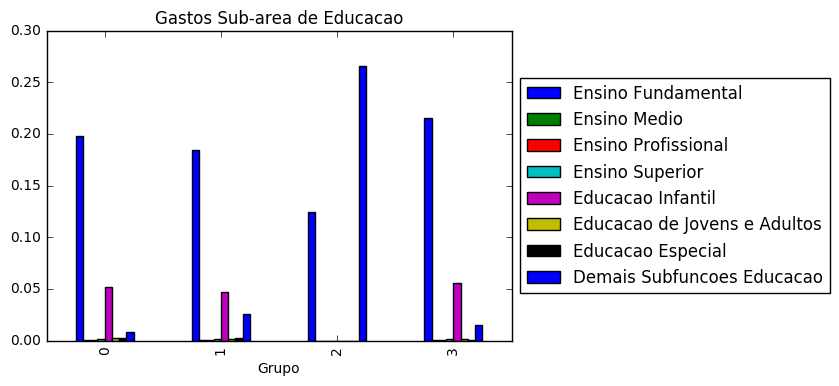

In [50]:
# Gastos das cidades em educacao
educacao_grupo = cidades_medias.loc[:,['Grupo','Ensino Fundamental','Ensino Medio','Ensino Profissional','Ensino Superior','Educacao Infantil','Educacao de Jovens e Adultos','Educacao Especial','Demais Subfuncoes Educacao',]]
sg_e = educacao_grupo.groupby('Grupo').mean();
display(sg_e)

grafico_barras(sg_e, "Gastos Sub-area de Educacao");

## Maiores cidades por região

## Maiores cidades por UF